# 1D Convolutional Neural Networks Tutorial

### About the data

Data for this tutorial comes from the [Human Activity Recognition Using Smartphones](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones) dataset, provided by the University of California Irvine Machine Learning Repository.

In order to populate the dataset, subjects wore a smartphone that recorded their **linear acceleration** (using an accelerometer) and **angular acceleration** (using a gyroscope) while performing **typical daily activities**. After the data was collected, segments of each data recording were labeled based on the activity of the subject during that period. (This was possible by consulting video recordings.) Possible data labels in this dataset are: **WALKING**, **WALKING_UPSTAIRS**, **WALKING_DOWNSTAIRS**, **SITTING**, **STANDING**, and **LAYING**.

The goal of our classifier will be to predict the label of a segment of recording based on accelerometer and gyroscope readings.

> Data details: there are **3 sets of x, y, z accelerations** for a total of 9 different signals in each input data point—3 linear gravitational accelerations, 3 linear "body" accelerations, and 3 angular accelerations. All signals have a sample rate of 50 Hz.)

In [1]:
# Imports:

# Array/DataFrame functions
import numpy as np
import pandas as pd

# File manipulations
import os

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Plotting functionality
import matplotlib.pyplot as plt
import matplotlib
# Set default plotting fonts
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras

2023-10-15 17:47:00.947349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 17:47:01.208656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-15 17:47:01.208703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-15 17:47:01.285328: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-15 17:47:04.059450: W tensorflow/stream_executor/platform/de

### Read in data

Before we read in test/training data, let's define a `read_data()` function (along with `read_data_test()` and `read_data_train()` that call on it) that will load in the data from a GitHub repository into test and training datasets.

In [3]:
def read_data(set_type = 'train'):
    """ Read data """
    
    # Fixed params
    n_class = 6
    n_steps = 128

    main_dir = 'https://raw.githubusercontent.com/MedlyticsUniversal/Data/main/Week2/week2_conv1d'

    if(set_type == 'train'):
        txt = '_train.txt'
    else:
        txt = '_test.txt'
    
    label_path = main_dir + '/y' + txt
    labels = pd.read_csv(label_path, header = None)
    
    list_of_channels = ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']
    
    X = np.zeros((len(labels), n_steps, len(list_of_channels)))
    
    for (i, channel) in enumerate(list_of_channels):
        label_path = main_dir + '/IntertialSignals/' + channel + txt
        dat_ = pd.read_csv(label_path, delim_whitespace = True, header = None)
        X[:,:,i] = dat_.to_numpy()
    
    # Return
    return X, labels[0].values, list_of_channels

def read_data_train():
    return read_data(set_type='train')

def read_data_test():
    return read_data(set_type='test')

In [4]:
# Call functions to load all data into variables

X_train, labels_train, list_ch_train = read_data_train()
X_test, labels_test, list_ch_test = read_data_test()

In [5]:
# Print out the shape of the data to verify its size

print('X_train.shape:')
print(X_train.shape)
print('\n')

print('X_test.shape:')
print(X_test.shape)

X_train.shape:
(7352, 128, 9)


X_test.shape:
(2947, 128, 9)


### Explaining the shape of the (training) data
Dimension 1: There are **7,352** recordings that are labeled as doing one of those activities.

Dimension 2: In each recording, there are **128** time steps.

Dimension 3: At each timestep, there are sensor **9** values (3 values each for linear gravitational acceleration, linear "body" acceleration, and angular acceleration).

### Plot signals from single data point

Text(0.5, 0.9, 'Example 587, Activity: LAYING')

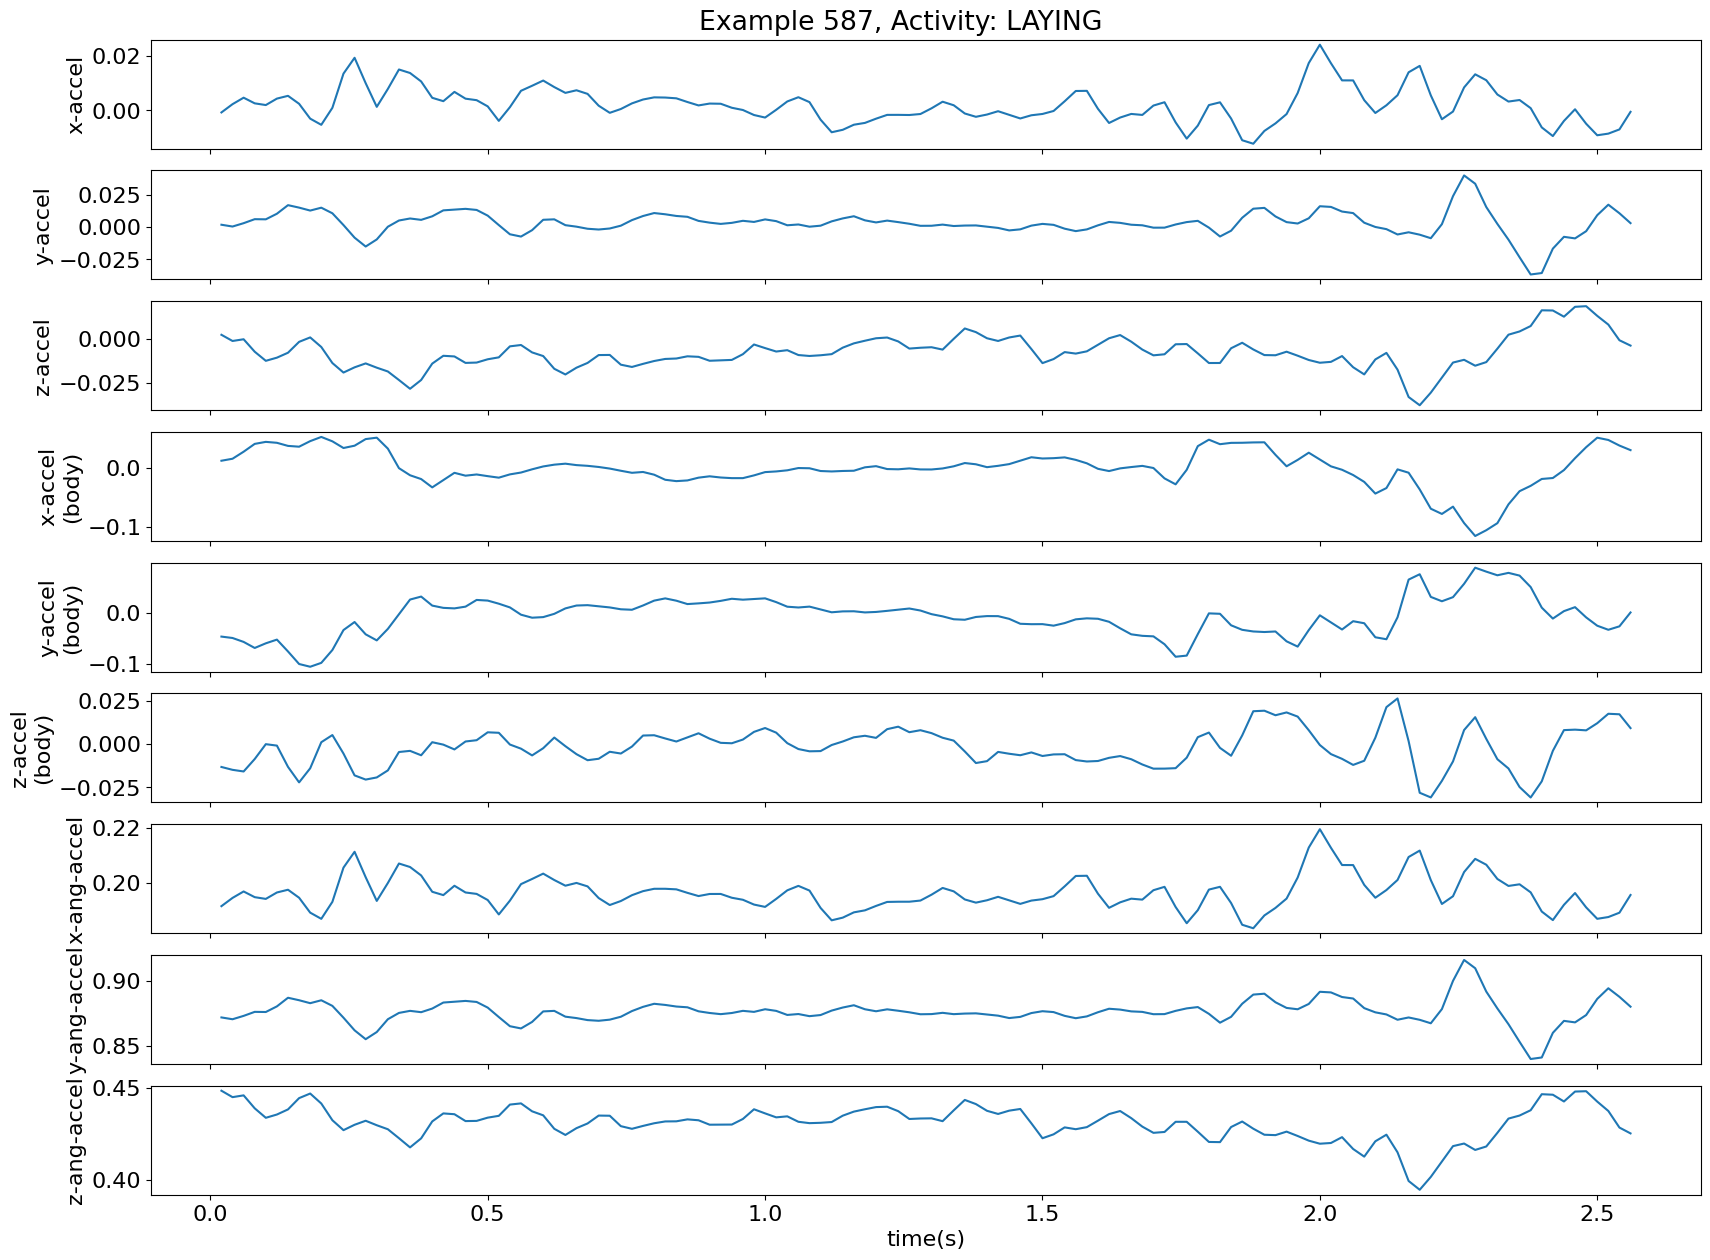

In [6]:
# Plot signals from a single data point to "see" signals data

# Get random sample number for plotting
sample_num = np.random.randint(0,X_train.shape[0]) # Get a random index
example_data_point = X_train[sample_num, :, :]
example_label_int = labels_train[sample_num]

# Define dictionaries to help label our plot

# Note that label integers actually vary from 1-6
labels2actions_dict = {1:'WALKING', 2: 'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
                   4:'SITTING', 5: 'STANDING', 6: 'LAYING'} 

signal_labels_dict = {0:'x-accel', 1: 'y-accel', 2:'z-accel',
                   3:'x-accel\n(body)', 4: 'y-accel\n(body)', 5: 'z-accel\n(body)',
                   6:'x-ang-accel', 7: 'y-ang-accel', 8: 'z-ang-accel'}

example_action = labels2actions_dict[example_label_int]

# Calculate time vector from sample rate (doesn't vary over dataset)
f_s = 50 # constant 50 Hz sampling rate
t_vector = np.linspace(start = 0.02, stop = 2.56 , num = 128)

# Make subplots for all signal channels
fig, axs = plt.subplots(example_data_point.shape[1], 1,
                        sharex = True,
                        figsize = (20, 15))

for signal_ind in range(example_data_point.shape[1]):
    axs[signal_ind].plot(t_vector, example_data_point[:, signal_ind])
    axs[signal_ind].set_ylabel(signal_labels_dict[signal_ind])

# Label x-axis
axs[-1].set_xlabel('time(s)')

# Set title based on what activity is being performed
plt.suptitle(f'Example {sample_num}, Activity: {example_action}', y = 0.9)

### Split "training" set into training and validation sets

When we loaded the data in, it comprised of two sets, so-called "training" and "test" sets. Now, however, there is a reason to divide the "training" set into a new training set and a development set. Together with the test set, this results in 3 groups of labeled data.

Breaking data into these **3 groups**—a training set, a development set, and a test set—happens when developers are trying to (1) train different models, (2) select the best model to fit the data, and (3) gauge the chosen model's performance on unlabeled data.

The typical sequence might go like this: first, prospective algorithms train on the training set. Afterwards, we can compare the performance of different algorithms by evaluating their accuracy on the development set. Finally, after we select an algorithm based on **train/dev set performance**, we can get an estimate of **real world** performance by computing model performance on the test set.

In [ ]:
# Split up training data so we can use part of it for a development set

# Below is a code block to scale training and test data
# This would make sure that the magnitudes of all measurements are similar
# before we train a model

# Uncomment this block to scale time series data
# (Performing this scaling will mean that the units of each datapoint are no longer in standard units)

'''
scaler = StandardScaler()
reshaped_X_train = X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2])).copy()
reshaped_X_test = X_test.reshape((X_test.shape[0]*X_test.shape[1], X_train.shape[2])).copy()

reshaped_X_train = scaler.fit_transform(reshaped_X_train)
reshaped_X_test = scaler.transform(reshaped_X_test)

X_train = reshaped_X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = reshaped_X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
'''

# Note: In the split, we stratify based on training labels to ensure that within
# each label, data is divided proportionately between the new training and validation sets

X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

### Load one-hot functions (to convert numeric labels)

Use these functions to convert all labels into one-hot encodings. This is a common step in machine learning classification problems.

When we convert labels to one-hot encodings, each label is represented by a row with a single value of 1 (at the column index of the label) and zeros for all other class labels.

For example, the encoding: `[0,0,0,0,0,1]` would represent the last label, `LAYING`.

This label representation is in contrast to the previous label where `LAYING` would just be represented as the integer `5`.

In [ ]:
# Define function to convert integer labels into one-hot encodings

def one_hot(labels, n_class = 6):
	""" 
		Replace integer entries in labels with their one-hot equivalents

		parameters:

			 labels  -- a 1D numpy array of integer labels

			 n_class -- the total number of classes

		returns:
		   y -- 2D numpy array where ith row corresponds to one-hot encoding
			 			of the integer in labels[i]
	"""
	
	# Make an identity matrix (ones on the diagonal, zeros everywhere else)
	expansion = np.eye(n_class)
 
	# Let the ith entry of y be the (label-1)th column of the identity matrix
	y = expansion[labels-1, :]

	return y

In [ ]:
# Convert labels into one-hot encoding (using above function)

y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

### Define your Keras model

For a straightforward example of Keras model creation of **convolutional neural networks (CNNs)**, you can refer to this example of a simple CNN used for classifying images in the MNIST database: https://github.com/keras-team/keras/blob/master/examples/demo_mnist_convnet.py (just be sure to note that the network uses 2D convolution, not 1D. So instead of using "conv2D" layers, we will be using "conv1D" layers.)

In [ ]:
# Define neural network structure using Keras

model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=18, kernel_size=2, strides=1, padding="same",  activation = tf.nn.relu, input_shape=(128, 9)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(6, activation=tf.nn.sigmoid))
model.summary()   

### Compile model

Before we can start training our Keras model, we need to compile it. When we compile the model, we also specify the optimizer, loss function, learning rate, and metrics. Here is a high level explanation of what these terms mean. We will have more discussion of them in future lectures. Also, please feel free to follow included links for more information in the Keras documentation.

**Loss Function**: This is the quantity that should be minimized when the network is trained. (It is like the mean squared error for a linear regression.) A neural network can use squared error as a loss function, but there are also other options. In the case of a neural network, trying to classify samples into 1 of $n$ categories is a common choice called cross-entropy loss.
> Documentation: https://keras.io/api/losses/

**Optimizer**: When a neural network is trained, it changes weights in the network to minimize the loss function. The optimizer governs how the neural network iteratively changes its weights as it minimizes loss. Many optimizers use the derivative of the loss function with respect to all the weights to decide which direction to change network weights.
> Documentation: https://keras.io/api/optimizers/

**Metrics**: These are quantities that you would like the model to "report" during the training process. You can specify multiple metrics.
> Documentation: https://keras.io/api/metrics/

**Learning Rate**: This scalar quantity determines how much the optimizer changes neural network weights between iterations. If this value is too low, it may delay convergence of the optimization. If this value is too high, the network weight optimization might overshoot useful solutions or not converge.

In [ ]:
# Define learning rate, optimizer, metrics, and loss function for your model as you compile it

lr = 0.0008 # Choose a learning rate
model.compile( optimizer=tf.compat.v1.train.AdamOptimizer(lr), 
              loss=keras.losses.categorical_crossentropy, metrics = ['accuracy'] )

### Fit your model

When you run this cell, the optimizer will attempt to tune the network weights to minimize the loss function. It does this by iteratively calculating the current loss function value of the network and intelligently changing the network weights to reduce that loss (this is where **gradient descent** comes in). Note that Keras lets us include the validation data as an input to the fitting function, so validation accuracy can be reported.

For reference, here are the definitions of "batch size" and "epochs" from the perspective of training a neural network:

**Batch Size**: In each iteration of the optimizer, the batch size controls how many data points are taken into account when calculating derivatives of the loss function. (If the batch size is less than the number of samples, there will be multiple optimization iterations per epoch.) More batches take longer but may reduce overfitting by considering a different set of samples in each optimizer iteration.

**Epochs**: This value controls how many times the data is passed through before optimization is finished. Specifying a higher number of epochs will obviously increase training time but might permit the optimizer to find a better set of network weights.

In [ ]:
# Fit model

history = model.fit(X_tr, # Train examples
                    y_tr, # Train labels
                    epochs=100, # Number of epochs (passes through data during training)
                    batch_size=600, # Number of points to consider in each optimizer iteration
                    validation_data=(X_vld, y_vld), #Data to use for validation
                    verbose=1) # Will print information about optimization process

### Evaluate model on test set
(After you print your accuracy and loss, play around with the parameters to try and improve the model performance.)

In [ ]:
# Evaluate model on test set

score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Conclusions

This notebook is meant to give you an example of **building a convolutional neural network in Keras**, which is one approach that can be used to solve the Week 2 Challenge Project.

While building and training your network might only take a handful of lines of code, understanding all the **magic** going on behind the scenes can and should take time. If you don't find you have a strong intuition for what is happening in a neural network during Week 2, don't worry. We will continue explaining the components of neural networks well into Week 3 as well.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2703ed7-f8b4-40f5-8dd1-77fe823e4d60' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>